# 7.a Uncertainty analysis via Jacknife

Jackknife resampling is a method that is similar to cross-validation and bootstrap, and it can also be used to estimate the uncertainty of a solution to an inverse problem. The main difference between jackknife resampling and cross-validation/bootstrap is that jackknife resampling involves leaving out one data point at a time, while cross-validation involves dividing the data into subsets, and bootstrap involves resampling the data with replacement.

In the case of highly contaminated data, jackknife resampling can be useful because it allows you to estimate the uncertainty of the solution while considering the effect of individual data points. However, one of the main disadvantages of jackknife resampling is that it can be computationally expensive, especially for large datasets, as it requires solving the inverse problem multiple times, once for each data point that is left out.

In [49]:
import sys
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from statistics import mean
# Importing the main code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)
import ocloc
from ocloc import ProcessingParameters, ClockDrift, suppress_stdout
import contextlib

## Precomputed solutions for different parameter configurations

First let's take a quick look at the different precomputed solutions that we got for different parameter configurations. For each of them, we followed the steps before the refined inversion.

The thresholds we tested were:
1. SNR = [10, 20, 30, 40, 50, 60]
2. dist_trh = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

We tested all possible combinations between these thresholds.
Let us make a quick plot of how many correlations (per set of parameters) are available.

In [50]:
def load_clockdrift(snr_trh, dist_trh, 
                    dir_ClockDrifts = "./precomputed_clockdrift_objects"):
    """
    This function loads the clock drift object.

    Parameters
    ----------
    snr_trh : float
        The SNR threshold.
    dist_trh : float
        The distance threshold.
    dir_ClockDrifts : str
        The directory where the clock drift objects are stored.

    Returns
    -------
    cd : ClockDrift
        The clock drift object.

    """
    iteration = "snr_trh_" + str(snr_trh) + "__dist_trh_" + str(dist_trh)
    file_name = "ClockDrift_" + iteration + ".obj"
    path_2_clockdrift = os.path.join(dir_ClockDrifts, file_name)
    with open(path_2_clockdrift, 'rb') as f:
        cd = pickle.load(f) 
    return cd


# function to count the non nan correlation values
def count_non_nan_corr(cd):
    """
    This function counts the non nan correlation values.

    Parameters
    ----------
    cd : ClockDrift
        The clock drift object.

    Returns
    -------
    count : int
        The number of non nan correlation values.

    """
    count = 0
    for corr in cd.correlations:
        if not np.isnan(corr.t_app[-1]):
            count += 1
    return count


def remove_nan_corr(cd):
    """
    This function removes the correlation in cd.correlations that have a
    nan value in t_app[-1].
    This means, that the correlation did not meet the SNR and distance 
    thresholds, or that the program could not compute the 
    $t_{i, j, k}^{\mathrm{(+, app)}} + t_{i, j, k}^{\mathrm{(-, app)}}$.

    Parameters
    ----------
    cd : ClockDrift
        The clock drift object.

    Returns
    -------
    cd : ClockDrift
        The clock drift object.

    """
    cd.correlations = [corr for corr in cd.correlations if not np.isnan(corr.t_app[-1])]
    return cd

def get_last_a_value(self):
    """
    This function creates a dictionary where the keys are the station names
    and the values are the a[-1] values. Station names can be taken from
    cd.stations[i].code. Only stations that .needs_correction == True
    should be included in the dictionary.

    Parameters
    ----------
    cd : ClockDrift
        The clock drift object.

    Returns
    -------
    last_a_value : dict
        The dictionary with the a[-1] values as a list.

    """
    last_a_value = {}
    for station in self.stations:
        if station.needs_correction:
            if station.included_in_last_inversion:
                last_a_value[station.code] = [station.a[-1]]
            else:
                last_a_value[station.code] = [np.nan]
    return last_a_value

def get_last_b_value(self):
    """
    This function creates a dictionary where the keys are the station names
    and the values are the b[-1] values. Station names can be taken from
    cd.stations[i].code. Only stations that .needs_correction == True
    should be included in the dictionary.

    Parameters
    ----------
    cd : ClockDrift
        The clock drift object.

    Returns
    -------
    last_b_value : dict
        The dictionary with the b[-1] values as a list.

    """
    last_b_value = {}
    for station in self.stations:
        if station.needs_correction:
            if station.included_in_last_inversion:
                last_b_value[station.code] = [station.b[-1]]
            else:
                last_b_value[station.code] = [np.nan]
    return last_b_value

def combine_dicts(dict1, dict2):
    """
    This function combines two dictionaries with the same keys, where
    the values are lists, and returns a dictionary with the same keys
    and the values are the concatenation of the values of the two
    dictionaries.

    Parameters
    ----------
    dict1 : dict
        The first dictionary.
    dict2 : dict
        The second dictionary.

    Returns
    -------
    combined_dict : dict
        The combined dictionary.

    """
    combined_dict = {}
    for key in dict1.keys():
        combined_dict[key] = dict1[key] + dict2[key]
    return combined_dict

# function to plot a histogram from a list with the 5% and 95% quantiles 
# and the mean, and standard deviation. Set the x-axis to be in the range
# of the 1% and 99% quantiles.
def plot_hist(data, title, xlabel, ylabel, savefig=False, filename=None):
    """
    This function plots a histogram from a list with the 5% and 95% quantiles 
    and the mean, and standard deviation. Set the x-axis to be in the range
    of the 1% and 99% quantiles.

    Parameters
    ----------
    data : list
        The list with the data.
    title : str
        The title of the plot.
    xlabel : str
        The label of the x-axis.
    ylabel : str
        The label of the y-axis.
    savefig : bool, optional
        If True, the figure is saved as a png file. The default is False.
    filename : str, optional
        The filename of the saved figure. The default is None.

    Returns
    -------
    None.

    """
    # Calculate the mean and standard deviation.
    mean = np.mean(data)
    std = np.std(data)
    
    # Calculate the 5% and 95% quantiles.
    q5 = np.quantile(data, 0.05)
    q95 = np.quantile(data, 0.95)
    
    # Calculate the 1% and 99% quantiles.
    q1 = np.quantile(data, 0.01)
    q99 = np.quantile(data, 0.99)
    
    # Plot the histogram.
    plt.figure()
    plt.hist(data, bins=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(q5, color='r', linestyle='dashed', linewidth=1)
    plt.axvline(q95, color='r', linestyle='dashed', linewidth=1)
    plt.axvline(q1, color='r', linestyle='dashed', linewidth=1)
    plt.axvline(q99, color='r', linestyle='dashed', linewidth=1)
    plt.xlim(q1, q99)
    plt.show()
    
    if savefig:
        plt.savefig(filename, dpi=300)



# function to plot a histogram from a list with the 5% and 95% quantiles 
# and the mean, and standard deviation.
def plot_hist(data, title, xlabel, ylabel, savefig=False, filename=None):
    """
    This function plots a histogram from a list with the 5% and 95% quantiles 
    and the mean, and standard deviation.

    Parameters
    ----------
    data : list
        The list with the data.
    title : str
        The title of the plot.
    xlabel : str
        The label of the x-axis.
    ylabel : str
        The label of the y-axis.
    savefig : bool, optional
        If True, the figure is saved as a png file. The default is False.
    filename : str, optional
        The filename of the saved figure. The default is None.

    Returns
    -------
    None.

    """
    # Calculate the mean and standard deviation.
    mean = np.mean(data)
    std = np.std(data)
    
    # Calculate the 5% and 95% quantiles.
    q5 = np.quantile(data, 0.05)
    q95 = np.quantile(data, 0.95)

    # Calculate the 1% and 99% quantiles for plotting.
    q1 = np.quantile(data, 0.01)
    q99 = np.quantile(data, 0.99)

    # Plot the histogram.
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=100, density=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvline(q5, color="r", label="5% quantile")
    plt.axvline(q95, color="r", label="95% quantile")
    plt.axvline(mean, color="k", label="mean")
    plt.axvline(mean + std, color="k", linestyle="--", label="std")
    plt.axvline(mean - std, color="k", linestyle="--")
    plt.xlim(q1, q99)
    plt.legend()
    if savefig:
        plt.savefig(filename, dpi=300)
    plt.show()

def plot_jackknife_results(station, a_vals, b_vals, snr_trh, dist_trh, 
                           savefig=False, filename=None):
    """
    This function plots the jackknife results for a given station.

    Parameters
    ----------
    station : str
        The station name.
    a_vals : dict
        The dictionary with the a values for each station.
    b_vals : dict
        The dictionary with the b values for each station.
    snr_trh : float
        The signal-to-noise ratio threshold.
    dist_trh : float
        The distance threshold.
    savefig : bool, optional
        If True, the figure is saved as a png file. The default is False.
    filename : str, optional
        The filename of the saved figure. The default is None.

    Returns
    -------
    None.

    """
    # Plot the a values.
    plot_hist(a_vals[station], f"Jacknife a values for {station} (SNR > {snr_trh}, "
              f"dist > {dist_trh})", "a", "Frequency", savefig=savefig, 
              filename=filename)
    
    # Plot the b values.
    plot_hist(b_vals[station], f"Jacknife b values for {station} (SNR > {snr_trh}, "
              f"dist > {dist_trh})", "b", "Frequency", savefig=savefig, 
              filename=filename)


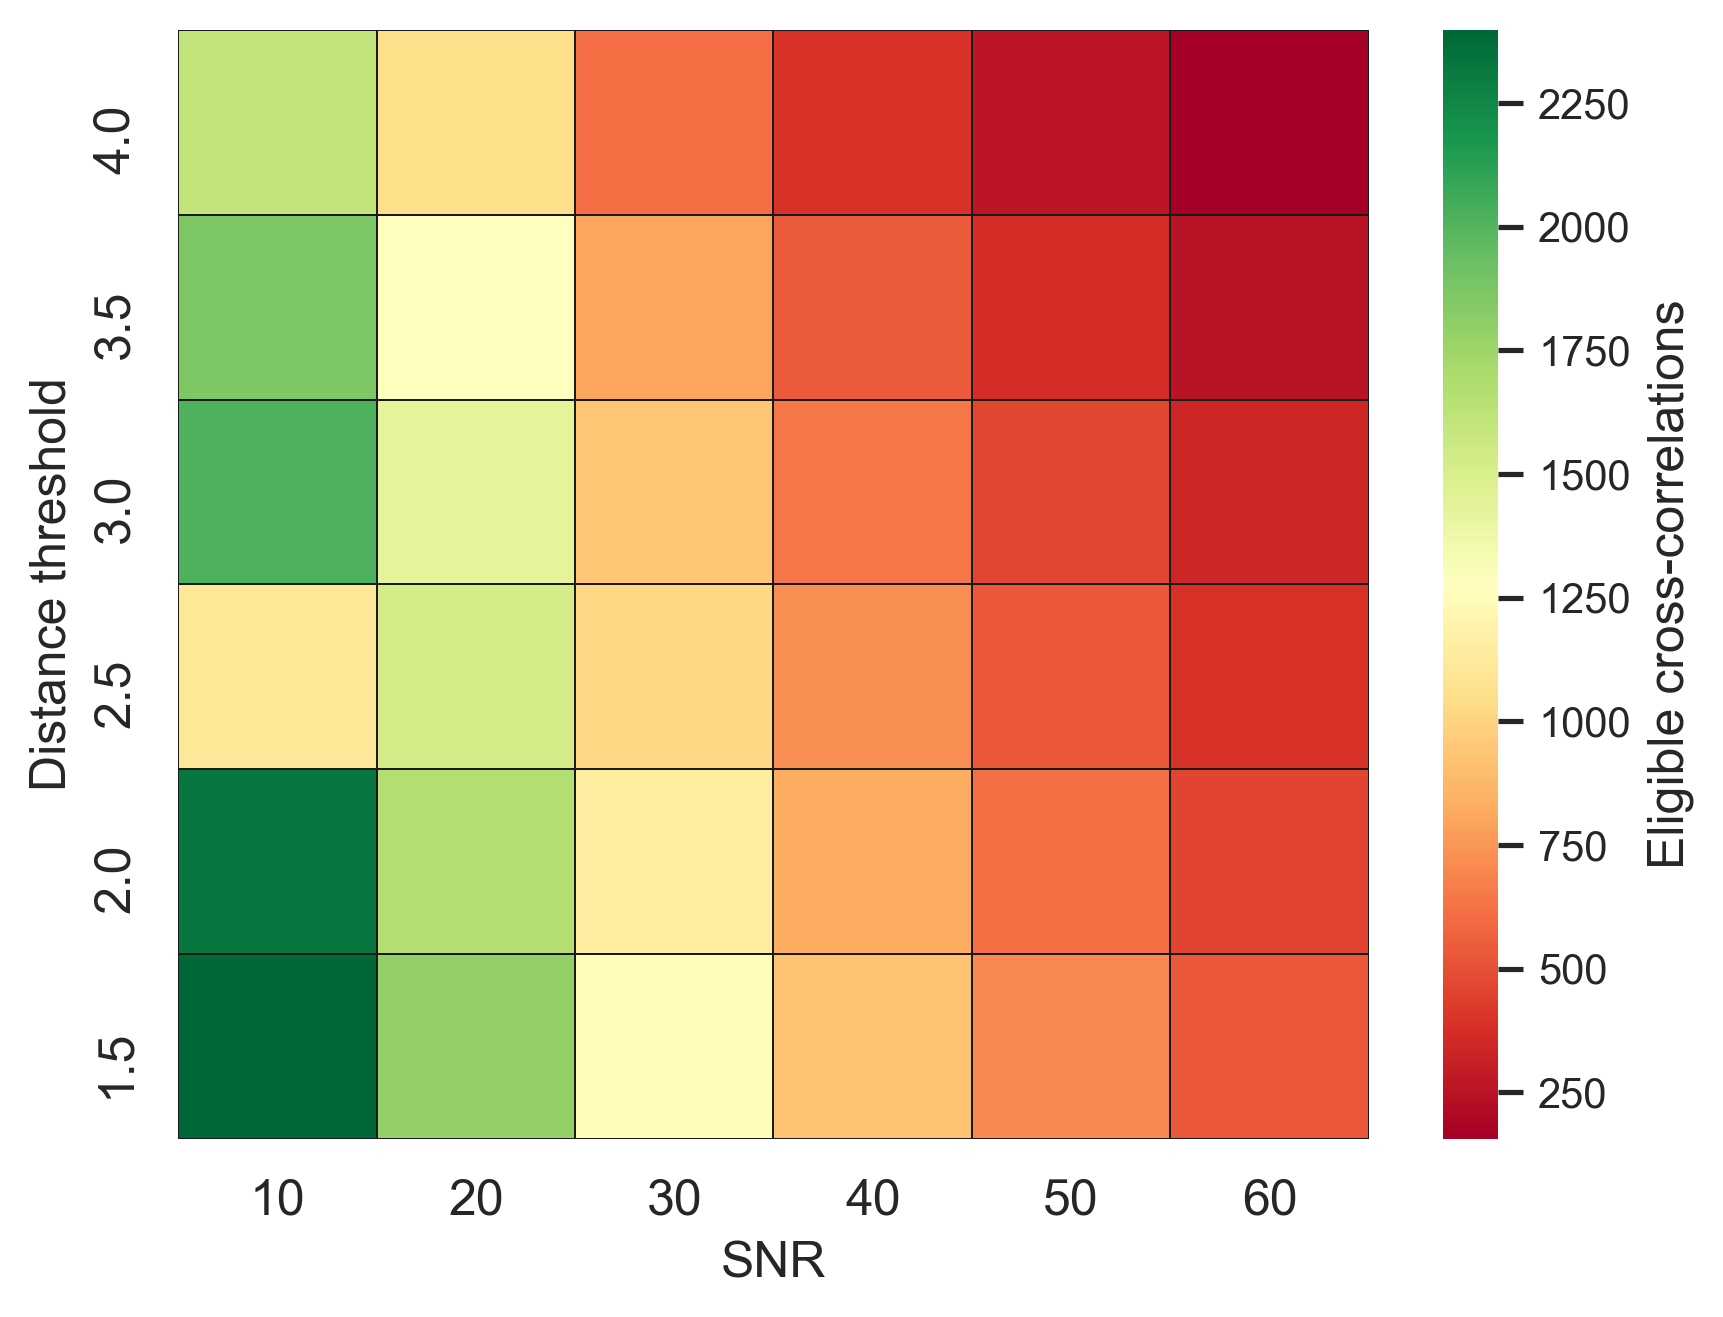

In [51]:
dir_ClockDrifts = "./precomputed_clockdrift_objects"
column_headers_SNR = [10, 20, 30, 40, 50, 60]
row_headers_dist_trh = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0] 

# Invert row_headers_dist_trh to get the same order as in the paper.
row_headers_dist_trh = row_headers_dist_trh[::-1]

matrix = []
for snr_trh in column_headers_SNR:
    column = []
    for dist_trh in row_headers_dist_trh:
        # Load the clock drift object.
        cd = load_clockdrift(snr_trh, dist_trh, dir_ClockDrifts)

        # Count the non nan correlation values.  
        column.append(count_non_nan_corr(cd))
    matrix.append(column)

ocloc.plot_matrix(matrix, column_headers_SNR, row_headers_dist_trh, 
                  xlabel="SNR", ylabel="Distance threshold", 
                  cmap_title="Eligible cross-correlations")


# Jacknife approach applied to SNR 30 and distance threshold 2.0.

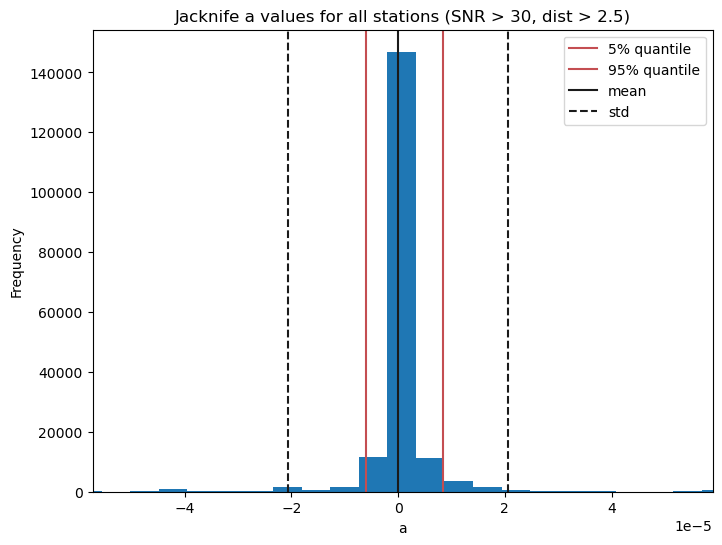

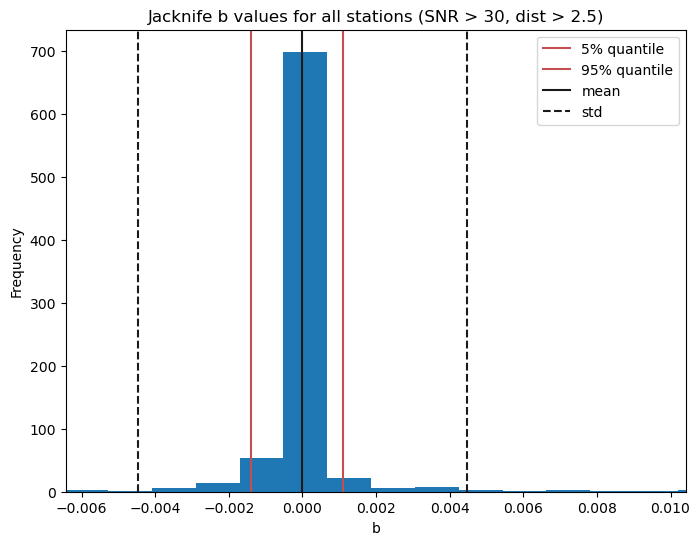

In [58]:
snr_trh = 30
dist_trh = 2.5

cd = load_clockdrift(snr_trh=snr_trh, dist_trh=dist_trh, 
                     dir_ClockDrifts=dir_ClockDrifts)

# Remove the correlation in cd.correlations that have 
# a nan value in t_app[-1].
cd = remove_nan_corr(cd)

# build the matrix A and the vector Tobs.
cd.build_matrices()

# Create an empty list to store the results
results = []

# Iterate over the rows of A and T
for index in range(len(cd.correlations)):
    
    cd2 = cd.copy()
    cd2.correlations[index].t_app[-1] = np.nan
    cd2 = remove_nan_corr(cd2)

    # Do not show output from calling a function.
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        cd2.build_matrices()
        cd2.solve_eq()
    
    if index == 0:
        a_vals = get_last_a_value(cd2)
        b_vals = get_last_b_value(cd2)
    else:
        a_vals = combine_dicts(a_vals, get_last_a_value(cd2))
        b_vals = combine_dicts(b_vals, get_last_b_value(cd2))

# Merge all the values in dict into a single list.
all_a_vals = {"all stations": [a - mean(a_vals[station]) for a in a_vals[station]] for station in a_vals}

# Save all_a_vals to a csv file.
df = pd.DataFrame(all_a_vals)
df.to_csv("jacknife_snr_trh" + str(snr_trh) + "dist_trh" 
          + str(dist_trh) + "all_a_vals.csv")

# Merge all the values in dict into a single list.
all_b_vals = {"all stations": [b - mean(b_vals[station]) for b in b_vals[station]] for station in b_vals}

# Save all_b_vals to a csv file.
df = pd.DataFrame(all_b_vals)
df.to_csv("jacknife_snr_trh" + str(snr_trh) + "dist_trh" 
          + str(dist_trh) + "all_b_vals.csv")

# Plot the a values.
plot_jackknife_results("all stations", all_a_vals, all_b_vals,
                       snr_trh, dist_trh, 
                       savefig=False, filename=None)

#for station in cd.stations:
#    plot_jackknife_results(station.code, a_vals, b_vals, snr_trh, dist_trh, 
#                           savefig=False, filename=None)
#    break



# Jacknife approach applied to SNR 20 and distance threshold 2.5.

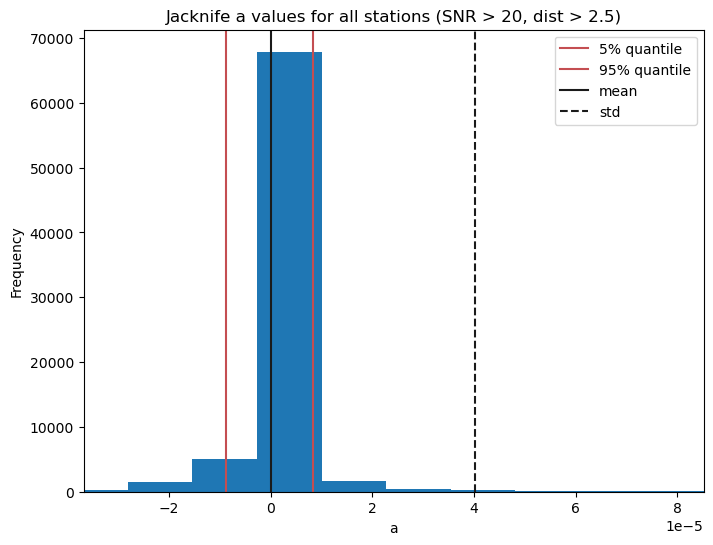

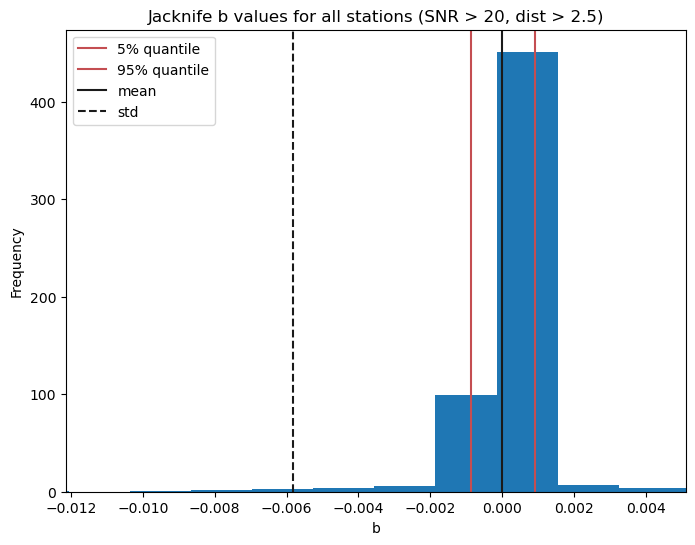

In [59]:
snr_trh = 20
dist_trh = 2.5

cd = load_clockdrift(snr_trh=snr_trh, dist_trh=dist_trh, 
                     dir_ClockDrifts=dir_ClockDrifts)

# Remove the correlation in cd.correlations that have 
# a nan value in t_app[-1].
cd = remove_nan_corr(cd)

# build the matrix A and the vector Tobs.
cd.build_matrices()

# Create an empty list to store the results
results = []

# Iterate over the rows of A and T
for index in range(len(cd.correlations)):
    
    cd2 = cd.copy()
    cd2.correlations[index].t_app[-1] = np.nan
    cd2 = remove_nan_corr(cd2)

    # Do not show output from calling a function.
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        cd2.build_matrices()
        cd2.solve_eq()
    
    if index == 0:
        a_vals = get_last_a_value(cd2)
        b_vals = get_last_b_value(cd2)
    else:
        a_vals = combine_dicts(a_vals, get_last_a_value(cd2))
        b_vals = combine_dicts(b_vals, get_last_b_value(cd2))

# Merge all the values in dict into a single list.
all_a_vals = {"all stations": [a - mean(a_vals[station]) for a in a_vals[station]] for station in a_vals}

# Save all_a_vals to a csv file.
df = pd.DataFrame(all_a_vals)
df.to_csv("jacknife_snr_trh" + str(snr_trh) + "dist_trh" 
          + str(dist_trh) + "all_a_vals.csv")

# Merge all the values in dict into a single list.
all_b_vals = {"all stations": [b - mean(b_vals[station]) for b in b_vals[station]] for station in b_vals}

# Save all_b_vals to a csv file.
df = pd.DataFrame(all_b_vals)
df.to_csv("jacknife_snr_trh" + str(snr_trh) + "dist_trh" 
          + str(dist_trh) + "all_b_vals.csv")

# Plot the a values.
plot_jackknife_results("all stations", all_a_vals, all_b_vals,
                       snr_trh, dist_trh, 
                       savefig=False, filename=None)

#for station in cd.stations:
#    plot_jackknife_results(station.code, a_vals, b_vals, snr_trh, dist_trh, 
#                           savefig=False, filename=None)
#    break

